In [1]:
file_name = 'data_bubonic_FCFP6_1024.csv'
file_path = '../../ml-data/MolSync/bayesian1/'+file_name # file
bins = 1024 # bins in fingerprints
n_split = 4 # # desirable stratified K-fold for cross-validation
test_set_size = 0.2 # approximate portion of dataset which will be used for test dataset 
seed = 0 # set to a value, thus the results are reproducible
# fraction of randomly subsampling of a major class sample, important for big datasets modelling
major_subsample = 1 # for kcnq 0.2 works nice
sub_folder = '20170508_results_bin1024' # sub-folder to save results and models 

In [2]:
import os
if not os.path.isdir(sub_folder):
    ! mkdir $sub_folder # make a new forlder to save the results

## ML Classifiers

**Classic ML methods:**
- Bernoulli Naive Bayes Classifier
- Linear LogisticRegression Classifier
- AdaBoost DecisionTree Classifier
- SVM with radial base function kernel Classifie
- KNN
- Random Forest

In [3]:
print("\nClassic Machine Learning Method classifiers with %d-fold cross-validation and %d%% test set split. \n" % (n_split, test_set_size*100))


Classic Machine Learning Method classifiers with 4-fold cross-validation and 20% test set split. 



In [4]:
# Importing nesessary modules
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import sys
import random
from itertools import cycle
from IPython.display import SVG
import h5py

# Load sklearn methods
from sklearn import linear_model, svm, naive_bayes, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection, utils
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, accuracy_score, make_scorer
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, precision_score, recall_score
from sklearn.metrics import r2_score, confusion_matrix, brier_score_loss, average_precision_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.externals import joblib

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# font and othere plot settings
plt.style.use('seaborn-darkgrid')
sns.set_context("poster")
plt.rcParams['font.family'] = 'sans-serif'

## Plotting helper functions

In [5]:
# helper for ROC plotting and AUC saving for the model
def ROC_plot(model, model_name, X_train, y_train_class, X_test, y_test_class, batch_size=None, lw=2, DNN=False):
    """
    This function will plot ROC curves for a model
    input:
    model: tuned classification model
    X_train, y_train, X_test, y_test: pre-processed dataseries, dataframes, or nupy arrays sutable for this model
    DNN: flag for classic ML or DNN model, default is False
    Output:
    dictionary: ('train', 'AUC'): roc_auc_tr*100, ('train', 'ACC'): ACC_tr, ('train', 'f1-score'): f1_tr, 
            ('train', 'Cohen_Kappa'): cohen_kappa_tr, ('train', 'Matthews_corr'): matthews_corr_tr, 
             ('train', 'Precision'): precision_tr, ('train', 'Recall'): recall_tr, 
            ('test', 'AUC'): roc_auc_ts*100, ('test', 'ACC'): ACC_ts, ('test', 'f1-score'): f1_ts, 
            ('test', 'Cohen_Kappa'): cohen_kappa_ts, ('test', 'Matthews_corr') : matthews_corr_ts, 
            ('test', 'Precision') : precision_ts, ('test', 'Recall'): recall_ts
    """
    if DNN:
        classes_tr = model.predict_classes(X_train.values, batch_size=batch_size, verbose=0)
        classes_ts = model.predict_classes(X_test.values, batch_size=y_test_class.shape[0], verbose=0)
        proba_tr = model.predict_proba(X_train.values, batch_size=batch_size, verbose=0)[:, 0]
        proba_ts = model.predict_proba(X_test.values, batch_size=y_test_class.shape[0], verbose=0)[:, 0]
    else:
        classes_tr = model.predict(X_train.values)
        classes_ts = model.predict(X_test.values)       
        proba_tr = model.predict_proba(X_train.values)[:, 1]
        proba_ts = model.predict_proba(X_test.values)[:, 1]
    
    ACC_tr = 100*accuracy_score(y_train_class, classes_tr)
    ACC_ts = 100*accuracy_score(y_test_class, classes_ts)
    accuracy = "train Accuracy = %.2f%%, test Accuracy = %.2f%%" % (ACC_tr, ACC_ts)
    
    f1_tr = 100*f1_score(y_train_class, classes_tr)
    f1_ts = 100*f1_score(y_test_class, classes_ts)
    f1_scores = "train f1-score = %.2f%%, test f1-score = %.2f%%" % (f1_tr, f1_ts)
    
    # train classification results 
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train_class, proba_tr)                               
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    # test classification results 
    fpr_ts, tpr_ts, thresholds_ts = roc_curve(y_test_class, proba_ts)                               
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    
    # Cohens Kappa
    cohen_kappa_tr = cohen_kappa_score(y_train_class, classes_tr)
    cohen_kappa_ts = cohen_kappa_score(y_test_class, classes_ts)
    cohen_kappa = "train Cohen Kappa = %.2f, test Cohen Kappa = %.2f" % (cohen_kappa_tr, cohen_kappa_ts)
    
    # Matthews correlation coefficient
    matthews_corr_tr = matthews_corrcoef(y_train_class, classes_tr)
    matthews_corr_ts = matthews_corrcoef(y_test_class, classes_ts)
    matthews_corr = "train Matthews correlation coefficient = %.2f, test Matthews correlation coefficient = %.2f" % (matthews_corr_tr, matthews_corr_ts)    

    # Precision
    precision_tr = precision_score(y_train_class, classes_tr)
    precision_ts = precision_score(y_test_class, classes_ts)
    precision = "train Precision = %.2f, test Precision = %.2f" % (precision_tr, precision_ts)    

    # Recall
    recall_tr = recall_score(y_train_class, classes_tr)
    recall_ts = recall_score(y_test_class, classes_ts)
    recall = "train Recall = %.2f, test Recall = %.2f" % (recall_tr, recall_ts)
    
    # print all metrics for test and test
    print('\nModelling results: \n%s \n%s \n%s \n%s \n%s \n%s \n' % (accuracy, f1_scores, cohen_kappa, 
                                                                matthews_corr, precision, recall))    
    
    # plot two ROC: train, test and train only
    fig = plt.figure(figsize=(13, 6))
    
    # Train and test ROC
    fig.add_subplot(1, 2, 1)    
    # plot 50%
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k')
    # plot train ROC
    plt.plot(fpr_tr, tpr_tr, lw=lw, color='r',
                 label='ROC %s (area = %0.2f%%)' % ('train', (roc_auc_tr*100)))
    # plot test ROC
    plt.plot(fpr_ts, tpr_ts, lw=lw+1, color='b', 
                 label='ROC %s (area = %0.2f%%)' % ('test', (roc_auc_ts*100)))
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for \n %s classifier \n' % model_name)
    plt.legend(loc="lower right")
    
    # Train ROC
    fig.add_subplot(1, 2, 2)    
    # plot 50%
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k')
    # plot train ROC
    plt.plot(fpr_tr, tpr_tr, lw=lw, color='r',
                 label='ROC (area = %0.2f%%)' % (roc_auc_tr*100))
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for \n %s classifier \n' % model_name)
    plt.legend(loc="lower right")
    
    plt.show()
       
    return {('train', 'AUC'): roc_auc_tr*100, ('train', 'ACC'): ACC_tr, ('train', 'f1-score'): f1_tr, 
            ('train', 'Cohen_Kappa'): cohen_kappa_tr, ('train', 'Matthews_corr'): matthews_corr_tr, 
             ('train', 'Precision'): precision_tr, ('train', 'Recall'): recall_tr, 
            ('test', 'AUC'): roc_auc_ts*100, ('test', 'ACC'): ACC_ts, ('test', 'f1-score'): f1_ts, 
            ('test', 'Cohen_Kappa'): cohen_kappa_ts, ('test', 'Matthews_corr') : matthews_corr_ts, 
            ('test', 'Precision') : precision_ts, ('test', 'Recall'): recall_ts}

def plot_reg_target(df_reg_target, name):
    """
    plot histogram of the continues target
    input:
    df_reg_target: as dataframe
    name: name of the target
    """
    df_reg_target.hist(bins=20, figsize=(8, 6), edgecolor='b')
    plt.title(name+" Histogram, bin=20 \n")
    plt.xlabel(name)
    plt.ylabel("Frequency")
    return 

def plot_reg_results(model_reg, model_name, name_reg, X, y_reg, test=True):
    """
    Function plots Actual values vs predicted values for regression models
    input:
    model: sklearn or keras (DNN) trained regression model 
    model_name: string, name of the model
    name_reg: string, name of y variable
    X, y_reg: pre-processed dataseries, dataframes, or nupy arrays sutable for this model
    test: test dataset True or False
    output:
    dictionary: {'R2_squared' : r2_results}, where r2_results is a coefficient of determination R^2 
    """
    if test:
        ds_type = 'test'
    else:
        ds_type = 'train'
    predict_model_reg = model_reg.predict(X.values)
    r2_results = r2_score(y_reg, predict_model_reg)
    plt.figure(figsize=(10, 8))
    sns.regplot(predict_model_reg, y_reg, ci=False)
    plt.legend([model_name+' regression', name_reg], loc=2)
    plt.xlabel("Actual values of "+name_reg)
    plt.ylabel("Predicted values of "+name_reg)
    plt.title("Predicted vs Actual values for %s dataset \n coefficient of determination R^2 = %.4f" % (ds_type, r2_results))
    return {'R2_squared' : r2_results}

def plot_heat_maps_cm(cm_tr, cm_ts):
    """
    plots confusion matrix heat map
    input:
    confusion matrix
    """
    fig = plt.figure(figsize=(13,4))
    fig.add_subplot(1, 2, 1)
    sns.heatmap(cm_tr, annot=True, annot_kws={'fontsize': 12},  fmt = 'd')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    sns.plt.title('Confusion matrix for %s dataset \n' % 'train')
    
    fig.add_subplot(1, 2, 2)
    sns.heatmap(cm_ts, annot=True, annot_kws={'fontsize': 12},  fmt = 'd')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    sns.plt.title('Confusion matrix for %s dataset \n' % 'test')
    plt.show()
    return None

def plot_cm_final(model, model_name, X_tr, y_tr, X_ts, y_ts, batch_size=None, DNN=True):
    """
    plotting final confusion matrix
    """
    if DNN:
        y_pred_ts = model.predict_classes(X_ts.values, batch_size=X_ts.shape[0], verbose=0)
        y_pred_tr = model.predict_classes(X_tr.values, batch_size=batch_size, verbose=0)
    else:
        y_pred_tr = model.predict(X_train.values)
        y_pred_ts = model.predict(X_test.values) 
    # confusion matixes
    cm_ts = confusion_matrix(y_ts, y_pred_ts)
    cm_tr = confusion_matrix(y_tr, y_pred_tr)
    print('\n'+model_name+'\n')
    plot_heat_maps_cm(cm_tr, cm_ts)
    return None

def test_results_plot(model, model_name, X_test, y_test_class, batch_size=None, lw=2, DNN=False):
    """
    This function will plot test ROC curve and confusion matrix for a model
    input:
    model: sklearn tuned classification model
    X_test, y_test: pre-processed dataseries, dataframes, or nupy arrays sutable for this model
    DNN: flag for classic ML or DNN model, default is False
    Output:
    dictionary: 'AUC': roc_auc_ts*100, 'ACC': ACC_ts, 'f1-score': f1_ts, 'Cohen_Kappa': cohen_kappa_ts, 
            'Matthews_corr' : matthews_corr_ts, 'Precision': precision_ts, 'Recall': recall_ts
    """
    if DNN:
        classes_ts = model.predict_classes(X_test.values, batch_size=y_test_class.shape[0], verbose=0)
        proba_ts = model.predict_proba(X_test.values, batch_size=y_test_class.shape[0], verbose=0)[:, 0]
    else:
        classes_ts = model.predict(X_test.values)       
        proba_ts = model.predict_proba(X_test.values)[:, 1]
    
    ACC_ts = 100*accuracy_score(y_test_class, classes_ts)
    accuracy = "test Accuracy = %.2f%%" % ( ACC_ts)
    
    f1_ts = 100*f1_score(y_test_class, classes_ts)
    f1_scores = "test f1-score = %.2f%%" % (f1_ts)
    
    # test classification results 
    fpr_ts, tpr_ts, thresholds_ts = roc_curve(y_test_class, proba_ts)                               
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    
    # Cohens Kappa
    cohen_kappa_ts = cohen_kappa_score(y_test_class, classes_ts)
    cohen_kappa = "test Cohen Kappa = %.2f" % (cohen_kappa_ts)
    
    # Matthews correlation coefficient
    matthews_corr_ts = matthews_corrcoef(y_test_class, classes_ts)
    matthews_corr = "test Matthews correlation coefficient = %.2f" % (matthews_corr_ts)    

    # Precision
    precision_ts = precision_score(y_test_class, classes_ts)
    precision = "test Precision = %.2f" % (precision_ts)    

    # Recall
    recall_ts = recall_score(y_test_class, classes_ts)
    recall = "test Recall = %.2f" % (recall_ts)
    
    # print all metrics for test and test
    print('\nModelling results: \n%s \n%s \n%s \n%s \n%s \n%s \n' % (accuracy, f1_scores, cohen_kappa, 
                                                                matthews_corr, precision, recall))    
    
    # plot two ROC: train, test and train only
    fig = plt.figure(figsize=(13, 6))
    
    # Test ROC
    fig.add_subplot(1, 2, 1)    
    # plot 50%
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k')
    # plot test ROC
    plt.plot(fpr_ts, tpr_ts, lw=lw+1, color='b', 
                 label='ROC %s (area = %0.2f%%)' % ('test', (roc_auc_ts*100)))
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for \n %s classifier \n' % model_name)
    plt.legend(loc="lower right")
    
    # Train ROC
    fig.add_subplot(1, 2, 2)    
    cm_ts = confusion_matrix(y_test_class, classes_ts)
    sns.heatmap(cm_ts, annot=True, annot_kws={'fontsize': 12},  fmt = 'd')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    sns.plt.title('Confusion matrix for %s dataset \n' % 'test')
    
    plt.show()
       
    return {'AUC': roc_auc_ts*100, 'ACC': ACC_ts, 'f1-score': f1_ts, 'Cohen_Kappa': cohen_kappa_ts, 
            'Matthews_corr' : matthews_corr_ts, 'Precision': precision_ts, 'Recall': recall_ts}

## Machine Learning classic models builder helper functions

In [6]:
# Bernoulli Naive Bayes Classifier with cross-validation
def Bayes_model(X_train, y_train_class, cw, k_fold=5, method='isotonic', alpha=1.0):
    """
    Return best Bernoulli Naive Bayes Classifier base on stratified k-fold cross validation 
    Input:
    X_train, y_train: pre-processed dataseries, dataframes, or nupy arrays
    cw: list of weights for test sample
    k_fold: parameter K for stratified K-fold cross-validation
    method: balancing classes method
    alpha: Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)
    Output:
    model: best Bernoulli Naive Bayes Classifier
    
    """
    start_tr = time.time()
    # build model
    clf_NB = naive_bayes.BernoulliNB(alpha=alpha) 
    # build a balanced classes cross-validation model
    clf_NB_isotonic = CalibratedClassifierCV(clf_NB, cv=k_fold, method=method)
    # fit model
    model_nb = clf_NB_isotonic.fit(X_train, y_train_class, np.array(cw))
    tr_time = (time.time() - start_tr)/60
    print('Training and tuning time is %.2f min' % tr_time)
    return model_nb


# Linear LogisticRegression Classifier with cross-validation
def LogisticRegression_model(X_train, y_train_class, class_weight=None, k_fold=5, scorer=roc_auc_score, seed=None):
    """
    Return best Linear Regression stratified k-fold cross validation model
    Input:
    X_train, y_train, X_test, y_test: pre-processed dataseries, dataframes, or nupy arrays
    class_weight: None, dictionary, or 'balanced'
    k_fold: parameter K for stratified K-fold cross-validation
    scorer: options for scoring, default are 
                roc_auc_score for maximizing ROC AUC, 
                f1_score for maximizing f1 score, 
                recall_score for maximizing sensitivity TP/All P
                accuracy_score for maximizing accuracy
    seed: None or int, random state
    Output:
    model1:  Linear Regression Classifier

    """
    start_tr = time.time()
    # define tuning parameters
    n_alphas_tmp = 5 # number of L2 penalties to use
    alphas_tmp = np.logspace(-5, -1, n_alphas_tmp)
    # define scorer function
    new_scorer = make_scorer(scorer)
    # Logistic Regression Classifier, L2 penalty
    clf_lr_l2 = linear_model.LogisticRegressionCV(Cs=alphas_tmp, cv=k_fold, solver='sag', penalty='l2', 
                                                    max_iter= 5000, random_state=seed, verbose=False, 
                                                  scoring=new_scorer, class_weight=class_weight)
    # Fit train data using Logistic Regression
    best_lr_l2_model = clf_lr_l2.fit(X_train, y_train_class)
    tr_time = (time.time() - start_tr)/60
    print('Training and tuning time is %.2f min' % tr_time)
    return best_lr_l2_model


# AdaBoost DecisionTree Classifier with cross-validation tuning
def AdaBoost_model(X_train, y_train_class, cw, k_fold=5,  method='isotonic', seed=None):
    """
    Return best AdaBoost stratified k-fold cross validated model
    Input:
    X_train, y_train, X_test, y_test: pre-processed dataseries, dataframes, or nupy arrays
    cw: list of weights for test sample 
    k_fold: parameter K for stratified K-fold cross-validation
    method: balancing classes method
    seed: None or int, random state
    Output:
    model_ab:  AdaBoost Classifier
    """
    start_tr = time.time()
    # build model
    clf_AB = ensemble.AdaBoostClassifier(n_estimators=100, learning_rate=0.9, random_state=seed)
    # build a balanced classes cross-validation model
    clf_AB_isotonic = CalibratedClassifierCV(clf_AB, cv=k_fold, method=method)
    # fit model
    model_ab = clf_AB_isotonic.fit(X_train, y_train_class, np.array(cw))
    tr_time = (time.time() - start_tr)/60
    print('Training and tuning time is %.2f min' % tr_time)
    return model_ab


# Random Forest Classifier with cross-validation tuning
def RF_model(X_train, y_train_class, class_weight=None, k_fold=5, scorer=roc_auc_score, seed=None):
    """
    Return best k-Nearest Neighbors Classifier stratified k-fold cross validated model
    Input:
    X_train, y_train, X_test, y_test: pre-processed dataseries, dataframes, or nupy arrays
    class_weight: None, dictionary, or 'balanced'
    k_fold: parameter K for stratified K-fold cross-validation
    scorer: options for scoring, default are 
                roc_auc_score for maximizing ROC AUC, 
                f1_score for maximizing f1 score, 
                recall_score for maximizing sensitivity TP/All P
                accuracy_score for maximizing accuracy
    seed: None or int, random state  
    Output:
    model_rf:  Random Forest Classifier
    """
    start_tr = time.time()
    # build model
    clf_RF = ensemble.RandomForestClassifier(max_depth=5, class_weight='balanced', random_state=seed)
    # define tuning parameters
    tuning_parameters = [{'n_estimators': [5, 10, 25]}] 
    # define scorer function
    new_scorer = make_scorer(scorer)
    # build a model
    model_clf_search = model_selection.GridSearchCV(clf_RF, tuning_parameters, cv=k_fold, scoring=new_scorer)
    # fit model
    model_rf = model_clf_search.fit(X_train, y_train_class)
    tr_time = (time.time() - start_tr)/60
    print('Training and tuning time is %.2f min' % tr_time)
    print("Best parameters for the RF model: \n", model_rf.best_params_)
    return model_rf


# SVM with radial base function kernel Classifier with cross-validation (combine into one function)
def  SVM_SVC_model(X_train, y_train_class, class_weight=None, k_fold=5, scorer=roc_auc_score, seed=None):
    """
    Return best SVM_SVC stratified k-fold cross validated model
    Input:
    X_train, y_train, X_test, y_test: pre-processed dataseries, dataframes, or nupy arrays
    class_weight: None, dictionary, or 'balanced'
    k_fold: parameter K for stratified K-fold cross-validation
    scorer: options for scoring, default are 
                roc_auc_score for maximizing ROC AUC, 
                f1_score for maximizing f1 score, 
                recall_score for maximizing sensitivity TP/All P
                accuracy_score for maximizing accuracy
    seed: None or int, random state    
    Output:
    model_svm:  AdaBoost Classifier
    """
    start_tr = time.time()
    # define tuning parameters
    tuning_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3], 'C': [1, 10]}] 
    # define scorer function
    new_scorer = make_scorer(scorer)
    # build a model
    model_clf_search = model_selection.GridSearchCV(svm.SVC(probability=True, class_weight='balanced', random_state=seed), 
                                                    tuning_parameters, cv=k_fold, scoring=new_scorer)
    # fit model
    model_svm = model_clf_search.fit(X_train, y_train_class)
    tr_time = (time.time() - start_tr)/60
    print('Training and tuning time is %.2f min' % tr_time)
    print("Best parameters for the SVM model: \n", model_svm.best_params_)
    return model_svm


# ElasticNet (Linear regression with L1 and L2 penalties)
def ElasticNetCV_model(X_train, y_train_reg, X_test, y_test_reg, k_fold=5):
    """
    Return best Elastic Net model (Linear regression with combined L1 and L2 priors as regularizer) 
    with iterative fitting along a regularization path base on stratified k-folds cross validation. 
    Input:
    X_train, y_train_logS, X_test, y_test_logS: pre-processed dataseries, dataframes, or nupy arrays
    k_fold: parameter K for stratified K-fold cross-validation, 3-fold is default
    Output:
    model: ElasticNet Classifier
    
    """
    start_tr = time.time()
    # define regularizaton constants and k-fold for cross validation
    l1_ratio = [0.05, 0.1, 0.15, .5, .8, .9] # a combination of L1 and L2 to use in cross validation
    alphas = np.logspace(-2.5, -1.5, 5) # 5 alphas
    cv = k_fold # k-Fold stratified split for train data
        
    # Run classifier with cross-validation 
    classifier = linear_model.ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, max_iter=5000, tol=0.0001, cv=cv, random_state=0) 
    best_EN_model = classifier.fit(X_train, y_train_reg)
    
    tr_time = (time.time() - start_tr)/60
    #print("Average k-fold mean square error for the test set varying l1_ratio and alpha")
    #print(best_EN_model.mse_path_.mean(axis=2))
    print('Training and tuning time is %.2f min' % tr_time)
    print("Best Elastic Net model train R^2 = %.4f and test R^2 = %.4f" % (best_EN_model.score(X_train, y_train_reg), 
                                                                      best_EN_model.score(X_test, y_test_reg)))
    print("were achieved with l1/l2 ratio = %.2f and alpha = %.2f" % (best_EN_model.l1_ratio_, best_EN_model.alpha_))
    return best_EN_model

## Load Data and prepare train and test datasets. 

In [7]:
df = pd.read_csv(file_path, index_col=0)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,class
count,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,...,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000
mean,0.991317,0.545297,0.972458,0.127054,0.977532,0.116563,0.640564,0.038104,0.293626,0.011463,...,0.370084,0.867644,0.062251,0.021732,0.022975,0.133257,0.028571,0.009576,0.020839,0.001594
std,0.092776,0.497946,0.163656,0.333034,0.148200,0.320900,0.479837,0.191448,0.455424,0.106449,...,0.482829,0.338879,0.241612,0.145807,0.149825,0.339853,0.166597,0.097388,0.142844,0.039888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Randonly remove a fraction of major class samples

In [8]:
if sum(df['class']) > df.shape[0]/2: 
    major_class = 1
    minor_class = 0
else:
    major_class = 0
    minor_class = 1
print("Original dataset:")
print("Major class is:", major_class, "sample size:", df[df["class"] == major_class].shape[0])
print("Minor class is:", minor_class, "sample size:", df[df["class"] == minor_class].shape[0])

Original dataset:
Major class is: 0 sample size: 139710
Minor class is: 1 sample size: 223


In [9]:
major_class_index = df[df["class"] == major_class].index
print("Original major class sample size is:", major_class_index.shape[0])
major_class_index_remove = np.random.choice(np.array(major_class_index), 
                                            int(major_class_index.shape[0] * (1. - major_subsample)), replace=False)
print("New major class sample size is:", major_class_index.shape[0] - major_class_index_remove.shape[0])

Original major class sample size is: 139710
New major class sample size is: 139710


In [10]:
df.drop(df.index[major_class_index_remove], inplace=True)
print("New dataset:")
print("Major class is:", major_class, "sample size:", df[df["class"] == major_class].shape[0])
print("Minor class is:", minor_class, "sample size:", df[df["class"] == minor_class].shape[0])
df.describe()

New dataset:
Major class is: 0 sample size: 139710
Minor class is: 1 sample size: 223


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,class
count,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,...,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000
mean,0.991317,0.545297,0.972458,0.127054,0.977532,0.116563,0.640564,0.038104,0.293626,0.011463,...,0.370084,0.867644,0.062251,0.021732,0.022975,0.133257,0.028571,0.009576,0.020839,0.001594
std,0.092776,0.497946,0.163656,0.333034,0.148200,0.320900,0.479837,0.191448,0.455424,0.106449,...,0.482829,0.338879,0.241612,0.145807,0.149825,0.339853,0.166597,0.097388,0.142844,0.039888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_features = df.ix[:,:bins]
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139933 entries, 0 to 139932
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 1.1 GB


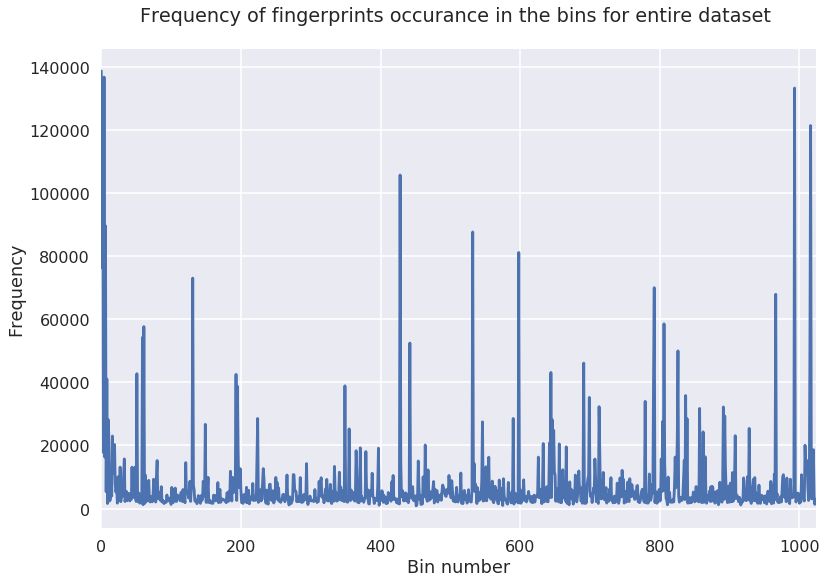

In [12]:
df_features.sum(axis=0).plot()
plt.title("Frequency of fingerprints occurance in the bins for entire dataset \n")
plt.xlabel('Bin number')
plt.ylabel('Frequency')

In [13]:
df_class_target = df['class']

In [14]:
print("\nThere are total %d 'true' labeled molecules out from %d in the dataset \n" % (sum(df_class_target == 1), df_class_target.shape[0]))
print("Baseline prediction (all 'true', metric - accuracy) is %0.2f%%" % (100*sum(df_class_target == 1)/df_class_target.shape[0]))
print("Baseline prediction (all 'false', metric - accuracy) is %0.2f%% \n" % (100 - 100*sum(df_class_target == 1)/df_class_target.shape[0]))


There are total 223 'true' labeled molecules out from 139933 in the dataset 

Baseline prediction (all 'true', metric - accuracy) is 0.16%
Baseline prediction (all 'false', metric - accuracy) is 99.84% 



### Split to train and test datasets. 

In [15]:
# stratified split base on test dataset size (test_set_size) and K-fold split (n_split)
batch_size = int(df_class_target.shape[0]*(1-test_set_size) // n_split) # callculating batch size
train_size = int(batch_size * n_split)
X_train_tmp, X_test_tmp, y_train_class_tmp, y_test_class = model_selection.train_test_split(df.ix[:,0:(bins+1)], 
                                    df_class_target, train_size=train_size, stratify=df_class_target, random_state=seed)
print('train size = %d, batch size = %d, test size = %d' % (train_size, batch_size, y_test_class.shape[0]))

train size = 111944, batch size = 27986, test size = 27989


In [16]:
# prepera dataset indexes for stratified K-fold split
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=n_split, random_state=0) 
valid_idx = [] # indexes for new train dataset
for (_, valid) in cv.split(X_train_tmp, y_train_class_tmp):
    valid_idx += valid.tolist()

In [17]:
X_train = X_train_tmp.iloc[valid_idx].ix[:,:bins]
print("Train features info:")
print(X_train.info())
X_train.describe()

Train features info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 111944 entries, 112174 to 97918
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 875.4 MB
None


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,...,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000,111944.000000
mean,0.991183,0.544835,0.972424,0.126938,0.977551,0.115987,0.640508,0.038216,0.293665,0.011577,...,0.022252,0.370212,0.867818,0.061834,0.021377,0.022913,0.132843,0.028273,0.009335,0.020778
std,0.093484,0.497988,0.163756,0.332906,0.148138,0.320210,0.479854,0.191717,0.455442,0.106973,...,0.147503,0.482863,0.338690,0.240856,0.144637,0.149628,0.339407,0.165753,0.096166,0.142642
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
X_test = X_test_tmp.ix[:,:bins]
print("Test features info:")
print(X_test.info())
X_test.describe()

Test features info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27989 entries, 74196 to 17879
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 218.9 MB
None


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,...,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000,27989.000000
mean,0.991854,0.547144,0.972596,0.127514,0.977455,0.118868,0.640787,0.037658,0.293472,0.011004,...,0.021151,0.369574,0.866948,0.063918,0.023152,0.023223,0.134910,0.029762,0.010540,0.021080
std,0.089889,0.497781,0.163259,0.333554,0.148449,0.323639,0.479778,0.190370,0.455361,0.104325,...,0.143891,0.482698,0.339637,0.244611,0.150389,0.150615,0.341634,0.169932,0.102123,0.143653
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
y_train_class = y_train_class_tmp.iloc[valid_idx]
print("Train class info:")
print(y_train_class.describe())

Train class info:
count    111944.000000
mean          0.001590
std           0.039844
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: class, dtype: float64


In [20]:
for i in range(n_split):
    print("True train target fraction for batch %d is %0.2f%%" % (i, 
                                        (y_train_class.iloc[i*batch_size:(i+1)*batch_size].sum()/batch_size)*100))

True train target fraction for batch 0 is 0.16%
True train target fraction for batch 1 is 0.16%
True train target fraction for batch 2 is 0.16%
True train target fraction for batch 3 is 0.16%


In [21]:
print("Test class info:")
print(y_test_class.describe())

Test class info:
count    27989.000000
mean         0.001608
std          0.040066
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: class, dtype: float64


## The following datasets are ready for training and testing:
- X_train
- X_test
- y_train_class
- y_test_class
- y_train_reg
- y_test_reg

## Train classic Machine Learning models

In [22]:
# dictionary to save all the model performance characteristics
classic_ML_performance = {}

### Prepare weights for fitting

In [23]:
def cw_to_dict(y_class):
    """
    input: 1D array, labels
    output: balanced class weight dictionary
    """
    cw = utils.compute_class_weight('balanced', [0, 1], y_class) #compute class weight
    cw_dict = {}
    for idx in range(len(cw)):
        cw_dict[idx] = cw[idx] 
    return cw_dict

In [24]:
# dictionary of weights
cw_tr_dict = cw_to_dict(y_train_class)
cw_ts_dict = cw_to_dict(y_test_class)
print("Train class weights: \n", cw_tr_dict)
print("Test class weights: \n", cw_ts_dict)

Train class weights: 
 {0: 0.50079630656908181, 1: 314.44943820224717}
Test class weights: 
 {0: 0.50080518179215572, 1: 310.98888888888888}


In [25]:
# lists of weights for eash sample
cw_tr = [cw_tr_dict[idx] for idx in y_train_class]
cw_ts = [cw_ts_dict[idx] for idx in y_test_class]

### Bernoulli Naive Bayes Classifier

Training and tuning time is 0.18 min

Modelling results: 
train Accuracy = 81.31%, test Accuracy = 81.20% 
train f1-score = 1.56%, test f1-score = 0.87% 
train Cohen Kappa = 0.01, test Cohen Kappa = 0.01 
train Matthews correlation coefficient = 0.08, test Matthews correlation coefficient = 0.03 
train Precision = 0.01, test Precision = 0.00 
train Recall = 0.93, test Recall = 0.51 



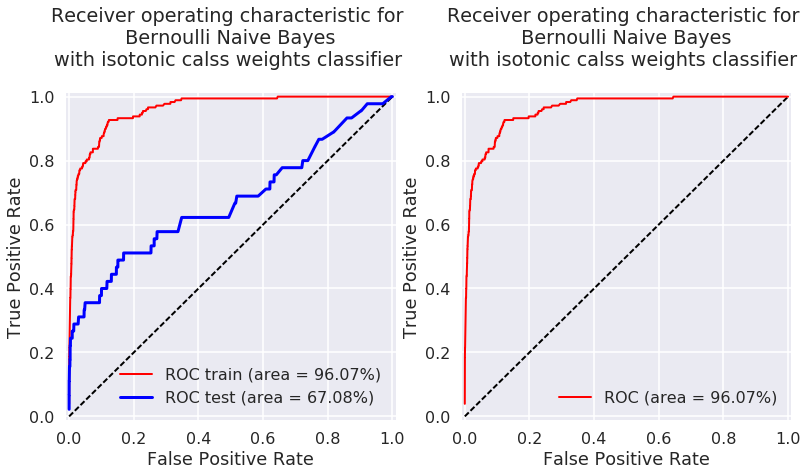


Bernoulli Naive Bayes 
with isotonic calss weights



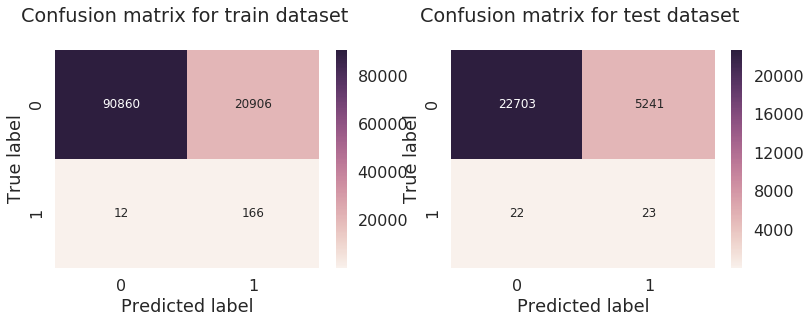

['20170508_results_bin1024/classic_ML_data_bubonic_FCFP6_1024_BayesNB_model.sav']

In [26]:
BayesNB_model = Bayes_model(X_train, y_train_class, cw_tr, n_split, 'isotonic')
# plot ROC curves
model_BNB_name ='Bernoulli Naive Bayes \nwith isotonic calss weights'
classic_ML_performance['NaiveBayes'] = ROC_plot(BayesNB_model, model_BNB_name, 
                                                          X_train, y_train_class, X_test, y_test_class)
# show confusion train and test matrixes
plot_cm_final(BayesNB_model, model_BNB_name, X_train, y_train_class, X_test, y_test_class, DNN=False)
# save model
filename_BNB = 'BayesNB_model.sav'
joblib.dump(BayesNB_model, sub_folder+'/'+'classic_ML_'+file_name[:-4]+'_'+filename_BNB)

### Linear LogisticRegression Classifier

/home/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training and tuning time is 1094.38 min

Modelling results: 
train Accuracy = 84.07%, test Accuracy = 83.69% 
train f1-score = 1.69%, test f1-score = 0.91% 
train Cohen Kappa = 0.01, test Cohen Kappa = 0.01 
train Matthews correlation coefficient = 0.08, test Matthews correlation coefficient = 0.03 
train Precision = 0.01, test Precision = 0.00 
train Recall = 0.86, test Recall = 0.47 



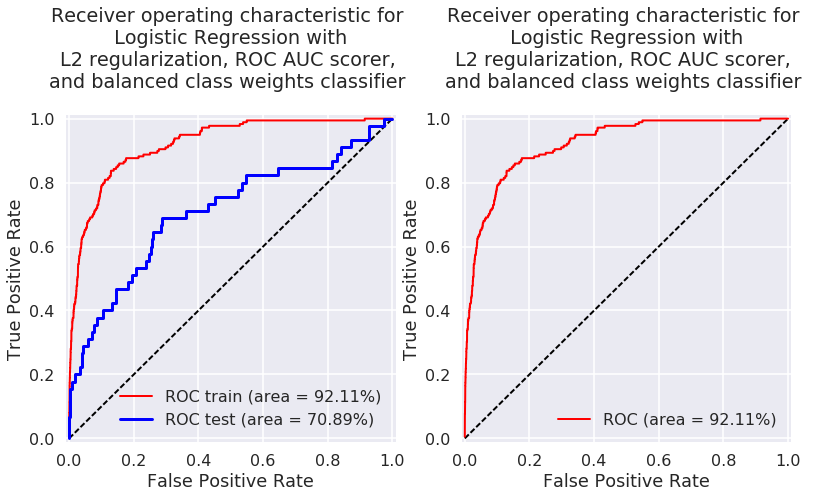


Logistic Regression with 
L2 regularization, ROC AUC scorer, 
and balanced class weights



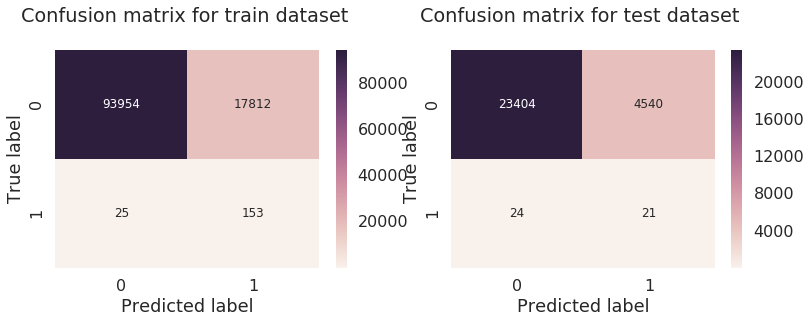

['20170508_results_bin1024/classic_ML_data_bubonic_FCFP6_1024_LR_L2_model.sav']

In [27]:
LR_L2_model = LogisticRegression_model(X_train, y_train_class, 'balanced', n_split, roc_auc_score, seed)
# plot ROC curves
model_LR_L2_name ='Logistic Regression with \nL2 regularization, ROC AUC scorer, \nand balanced class weights'
classic_ML_performance['LogisticRegression_L2'] = ROC_plot(LR_L2_model, model_LR_L2_name, 
                                                    X_train, y_train_class, X_test, y_test_class)
# show confusion train and test matrixes
plot_cm_final(LR_L2_model, model_LR_L2_name, X_train, y_train_class, X_test, y_test_class, DNN=False)
# save model
filename_LR_L2 = 'LR_L2_model.sav'
joblib.dump(LR_L2_model, sub_folder+'/'+'classic_ML_'+file_name[:-4]+'_'+filename_LR_L2)

### AdaBoost DecisionTree Classifier

Training and tuning time is 9.00 min

Modelling results: 
train Accuracy = 77.59%, test Accuracy = 76.96% 
train f1-score = 1.40%, test f1-score = 0.74% 
train Cohen Kappa = 0.01, test Cohen Kappa = 0.00 
train Matthews correlation coefficient = 0.07, test Matthews correlation coefficient = 0.03 
train Precision = 0.01, test Precision = 0.00 
train Recall = 1.00, test Recall = 0.53 



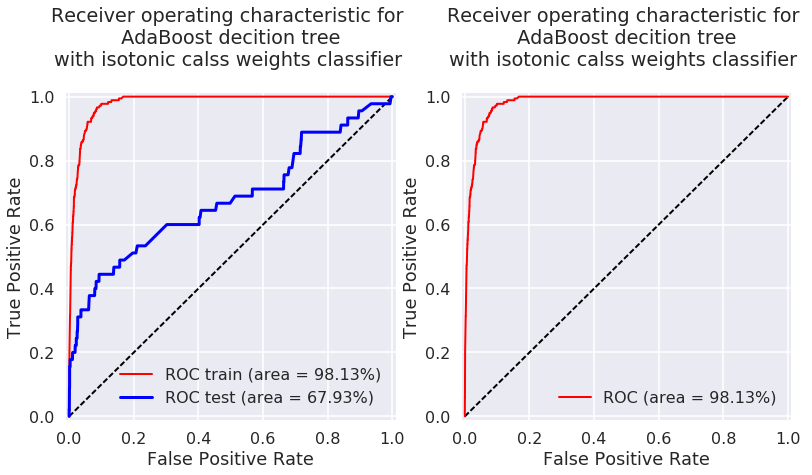


AdaBoost decition tree 
with isotonic calss weights



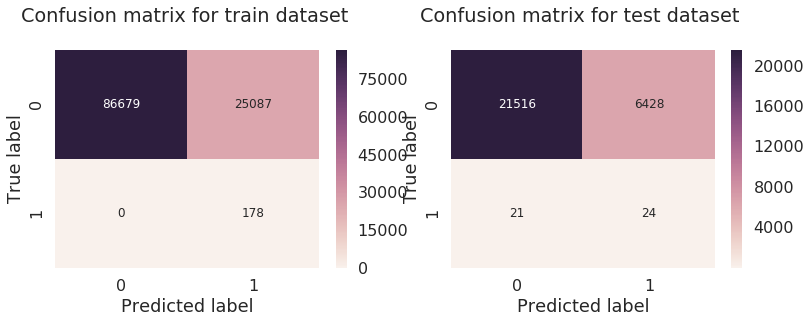

['20170508_results_bin1024/classic_ML_data_bubonic_FCFP6_1024_AdaBoost_DT_model.sav']

In [28]:
model_AB_tree = AdaBoost_model(X_train, y_train_class, cw_tr, n_split, 'isotonic', seed)
# plot ROC curves
model_AB_tree_name ='AdaBoost decition tree \nwith isotonic calss weights'
classic_ML_performance['AdaBoost_DT'] = ROC_plot(model_AB_tree, model_AB_tree_name, 
                                                      X_train, y_train_class, X_test, y_test_class)
# show confusion train and test matrixes
plot_cm_final(model_AB_tree, model_AB_tree_name, X_train, y_train_class, X_test, y_test_class, DNN=False)
# save model
filename_AB_tree = 'AdaBoost_DT_model.sav'
joblib.dump(model_AB_tree, sub_folder+'/'+'classic_ML_'+file_name[:-4]+'_'+filename_AB_tree)

### Random Forest Classifier

Training and tuning time is 0.44 min
Best parameters for the RF model: 
 {'n_estimators': 25}

Modelling results: 
train Accuracy = 91.92%, test Accuracy = 91.89% 
train f1-score = 2.60%, test f1-score = 1.30% 
train Cohen Kappa = 0.02, test Cohen Kappa = 0.01 
train Matthews correlation coefficient = 0.09, test Matthews correlation coefficient = 0.04 
train Precision = 0.01, test Precision = 0.01 
train Recall = 0.68, test Recall = 0.33 



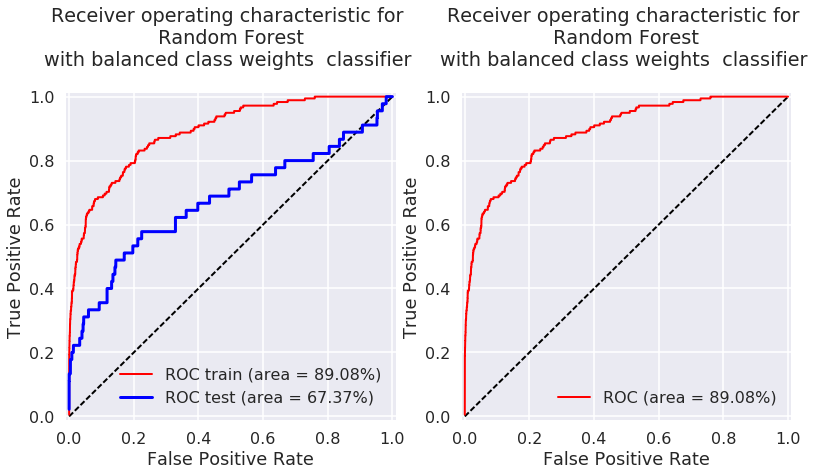


Random Forest 
with balanced class weights 



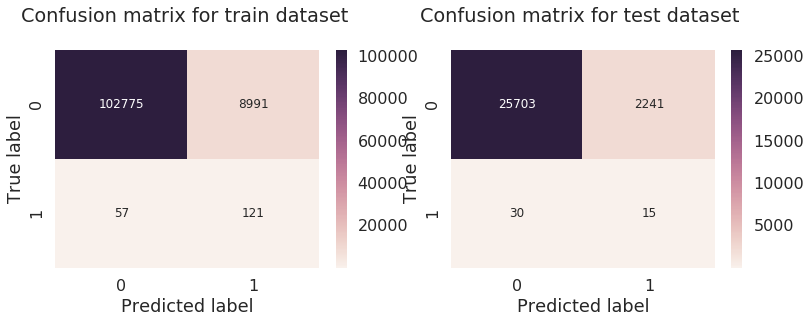

['20170508_results_bin1024/classic_ML_data_bubonic_FCFP6_1024_Random_Forest_model.sav']

In [29]:
model_RF = RF_model(X_train, y_train_class, 'balanced', n_split, roc_auc_score, seed)
# plot ROC curves
model_RF_name ='Random Forest \nwith balanced class weights '
classic_ML_performance['RandomForest'] = ROC_plot(model_RF, model_RF_name, 
                                                  X_train, y_train_class, X_test, y_test_class)
# show confusion train and test matrixes
plot_cm_final(model_RF, model_RF_name, X_train, y_train_class, X_test, y_test_class, DNN=False)
# save model
filename_RF = 'Random_Forest_model.sav'
joblib.dump(model_RF, sub_folder+'/'+'classic_ML_'+file_name[:-4]+'_'+filename_RF)

### SVM with radial base function kernel Classifier

Training and tuning time is 1775.10 min
Best parameters for the SVM model: 
 {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}

Modelling results: 
train Accuracy = 96.64%, test Accuracy = 96.60% 
train f1-score = 8.64%, test f1-score = 3.06% 
train Cohen Kappa = 0.08, test Cohen Kappa = 0.03 
train Matthews correlation coefficient = 0.21, test Matthews correlation coefficient = 0.07 
train Precision = 0.05, test Precision = 0.02 
train Recall = 1.00, test Recall = 0.33 



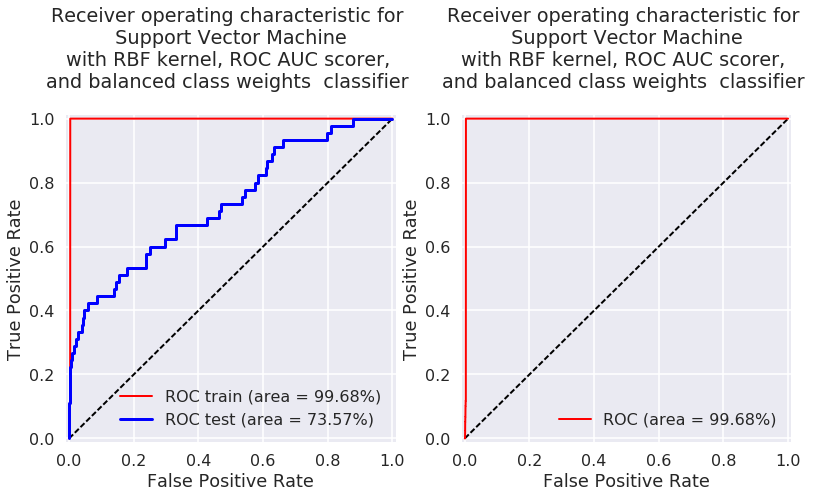


Support Vector Machine 
with RBF kernel, ROC AUC scorer, 
and balanced class weights 



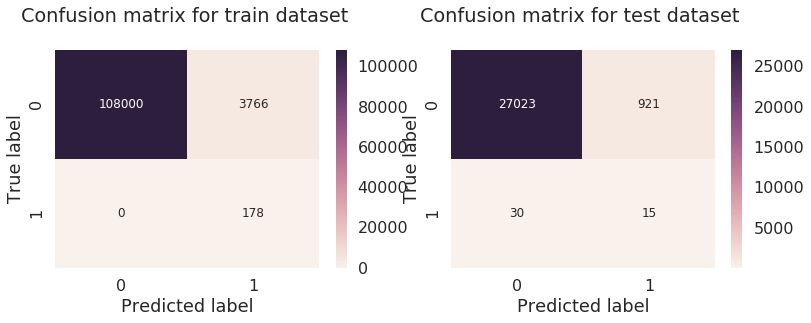

['20170508_results_bin1024/classic_ML_data_bubonic_FCFP6_1024_Support_Vector_Machine.sav']

In [30]:
model_SVM = SVM_SVC_model(X_train, y_train_class, 'balanced', n_split, roc_auc_score, seed)
# plot ROC curves
model_SVM_name ='Support Vector Machine \nwith RBF kernel, ROC AUC scorer, \nand balanced class weights '
classic_ML_performance['SupportVectorMachine'] = ROC_plot(model_SVM, model_SVM_name, 
                                                  X_train, y_train_class, X_test, y_test_class)
# show confusion train and test matrixes
plot_cm_final(model_SVM, model_SVM_name, X_train, y_train_class, X_test, y_test_class, DNN=False)
# save model
filename_SVM = 'Support_Vector_Machine.sav'
joblib.dump(model_SVM, sub_folder+'/'+'classic_ML_'+file_name[:-4]+'_'+filename_SVM)

In [31]:
# save results into a data frame
df_performance = pd.DataFrame.from_dict(classic_ML_performance)

In [32]:
# show data frame
df_performance

AdaBoost_DT  LogisticRegression_L2  NaiveBayes  \
test  ACC              76.958805              83.693594   81.196184   
      AUC              67.925216              70.890114   67.082339   
      Cohen_Kappa       0.004208               0.005953    0.005494   
      Matthews_corr     0.028853               0.033000    0.033174   
      Precision         0.003720               0.004604    0.004369   
      Recall            0.533333               0.466667    0.511111   
      f1-score          0.738803               0.911854    0.866453   
train ACC              77.589688              84.066140   81.313871   
      AUC              98.125651              92.105102   96.070595   
      Cohen_Kappa       0.010868               0.013760    0.012509   
      Matthews_corr     0.073918               0.076006    0.075991   
      Precision         0.007045               0.008517    0.007878   
      Recall            1.000000               0.859551    0.932584   
      f1-score          1.399206               1.686601    1.562353   

                     RandomForest  SupportVectorMachine  
test  ACC               91.886098             96.602237  
      AUC               67.366996             73.573496  
      Cohen_Kappa        0.009916              0.027598  
      Matthews_corr      0.037256              0.066937  
      Precision          0.006649              0.016026  
      Recall             0.333333              0.333333  
      f1-score           1.303781              3.058104  
train ACC               91.917387             96.635818  
      AUC               89.078215             99.680163  
      Cohen_Kappa        0.023002              0.083577  
      Matthews_corr      0.087329              0.208833  
      Precision          0.013279              0.045132  
      Recall             0.679775              1.000000  
      f1-score           2.604952              8.636584

In [33]:
# save csv file with all results
df_performance.to_csv(sub_folder+'/'+'classic_ML_'+file_name[:-4]+'.csv')

In [34]:
# Example of use model:

# Load model from disk
#loaded_model_BNB = joblib.load(sub_folder+'/'+'classic_ML_'+file_name[:-4]+'_'+filename_BNB)
#ROC_plot(loaded_model_BNB, model_BNB_name, X_train, y_train_class, X_test, y_test_class)
#loaded_model_BNB.score(X_test, y_test_class)

# For test or any dataset: print all metices, plot ROC and confusion matrix 
#test_results_plot(loaded_model_BNB, model_BNB_name, X_test, y_test_class)